## Environment

In [1]:
import reproducibility

In [2]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
# from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2
%matplotlib inline

# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan, load_and_fix_data
from data_funcs import raws_data, synthetic_data, plot_data, check_data, rmse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import run_case, run_rnn, create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict


## User Controls

In [3]:
dict_path = 'data/raws_dat.pickle'

In [4]:
stid = ['CPTC2', 'CHRC2', 'DYKC2', 'LPFC2', 'RRAC2', 'TT562', 'TT696']
tstart = '2023-05-01T00:23:00Z'
tend = '2023-08-31T00:23:00Z'

## Data Management

In [5]:
dat={}
dat.update(load_and_fix_data(dict_path))

After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan

In [6]:
def filter_dict(dat, tstart, tend):
    # Given FMDA dictionary, filter relevant fields to given time period
    # Inputs:
    # dat: FMDA dictionary
    # tstart: (str) start time
    # tend: (str) end time
    # Assuming UTC format for times
    # Return: FMDA dictionary filtered in time

    print(f'Filtering data to: {tstart} to {tend}')
    
    dat=dat.copy()
    # Get boolean array to control filtered values
    inds = (dat['time']>=tstart) & (dat['time']<=tend)
    # Filter relevant fields using previous
    dat['rain']=dat['rain'][inds]
    dat['solar']=dat['solar'][inds]
    dat['temp']=dat['temp'][inds]
    dat['fm']=dat['fm'][inds]
    dat['rh']=dat['rh'][inds]
    dat['wind_speed']=dat['wind_speed'][inds]
    dat['Ed']=dat['Ed'][inds]
    dat['Ew']=dat['Ew'][inds]

    dat['hours']=len(dat['fm'])
    
    print(f"Filtered data length: {dat['hours']}")
    
    return dat

In [7]:
# Set up testing dict
test_dict = {}
for st in stid:
    print(st)
    test_dict[st]=filter_dict(dat[st], 
                        tstart=tstart, 
                        tend=tend)
    # Set training period 
    test_dict[st]['h2']=int(np.ceil(test_dict[st]['hours']*(3/4)))
    # Analysis title
    test_dict[st]['title']="Long Train at RAWS "+st

CPTC2
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2928
CHRC2
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2926
DYKC2
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2922
LPFC2
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2925
RRAC2
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2926
TT562
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2927
TT696
Filtering data to: 2023-05-01T00:23:00Z to 2023-08-31T00:23:00Z
Filtered data length: 2927


## Run Model

In [8]:
param_sets={}
param_sets.update({0:{'id':0,   
        'purpose':'reproducibility',
        'cases':stid,
        'scale':0,
        'rain_do':False,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'centering':[0.0,0.0],
        'hidden_units':6,
        'dense_units':1,
        'dense_layers':1,
        'DeltaE':[0,-1],    # -1.0 is to correct E bias but put at the end
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain                              
        'epochs':5000,
        'verbose_fit':False,
        'verbose_weights':False,
        'note':'check 5 should give zero error'
}})

In [9]:
reproducibility.set_seed()

resetting random seeds to 123


i= 0
cases= ['CPTC2', 'CHRC2', 'DYKC2', 'LPFC2', 'RRAC2', 'TT562', 'TT696']
case= CPTC2

*****  CPTC2  *****

CPTC2 Training 1 to 2196 hours RMSE:   0.5335
CPTC2 Prediction 2197 to 2928 hours RMSE: 4.6146
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


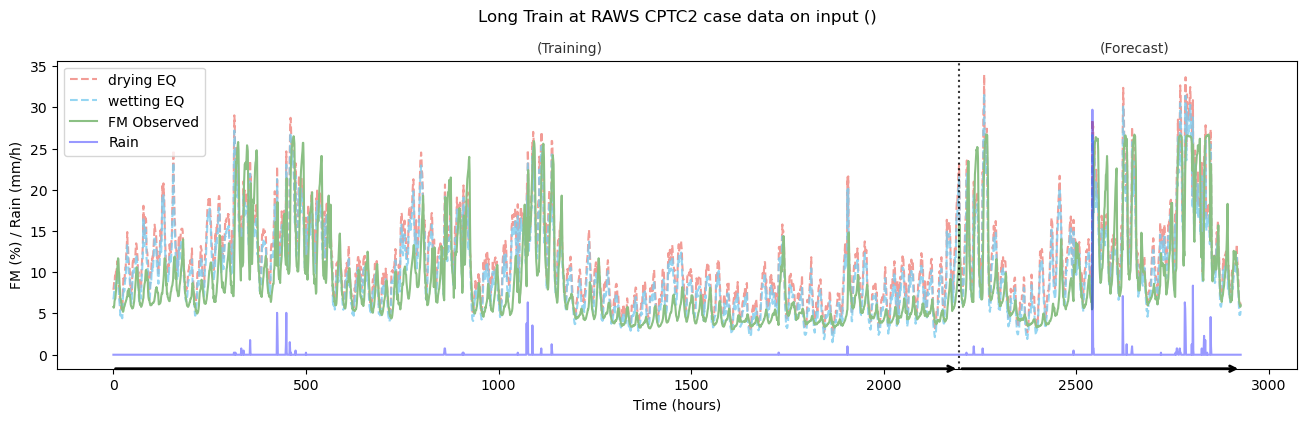

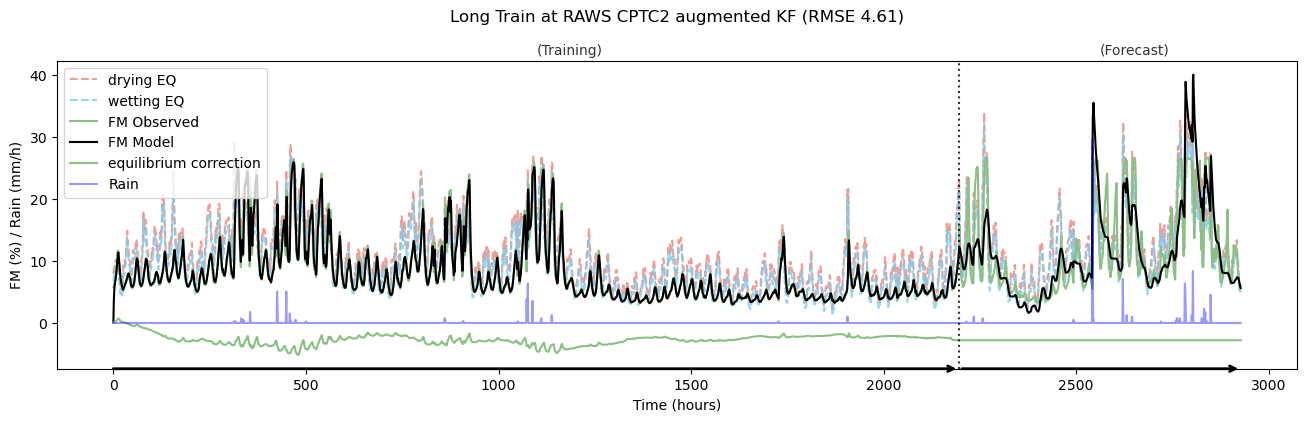

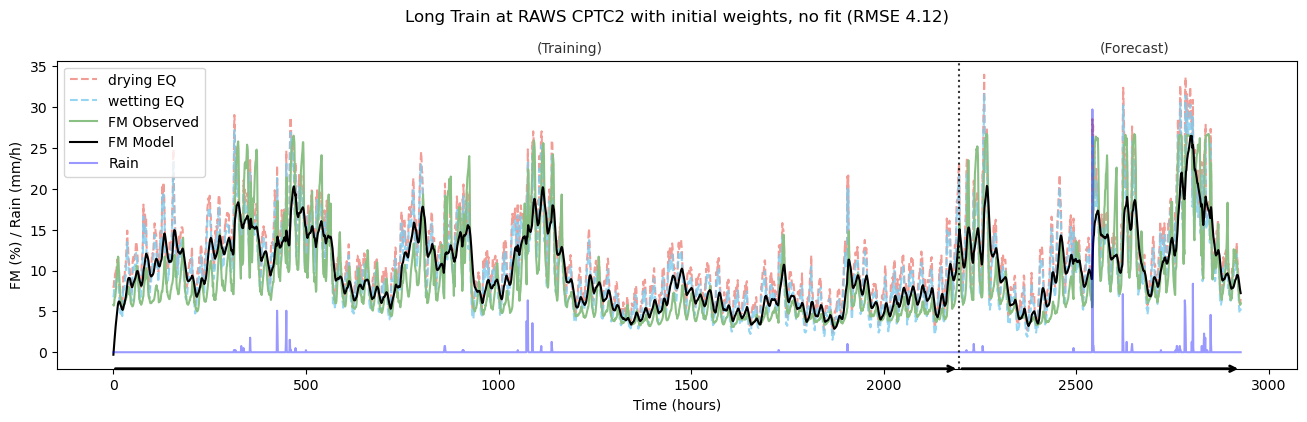

CPTC2 Training 1 to 2196 hours RMSE:   2.811
CPTC2 Prediction 2197 to 2928 hours RMSE: 4.1179
resetting random seeds to 123
check - hash weights: 5.610000577175211e+19


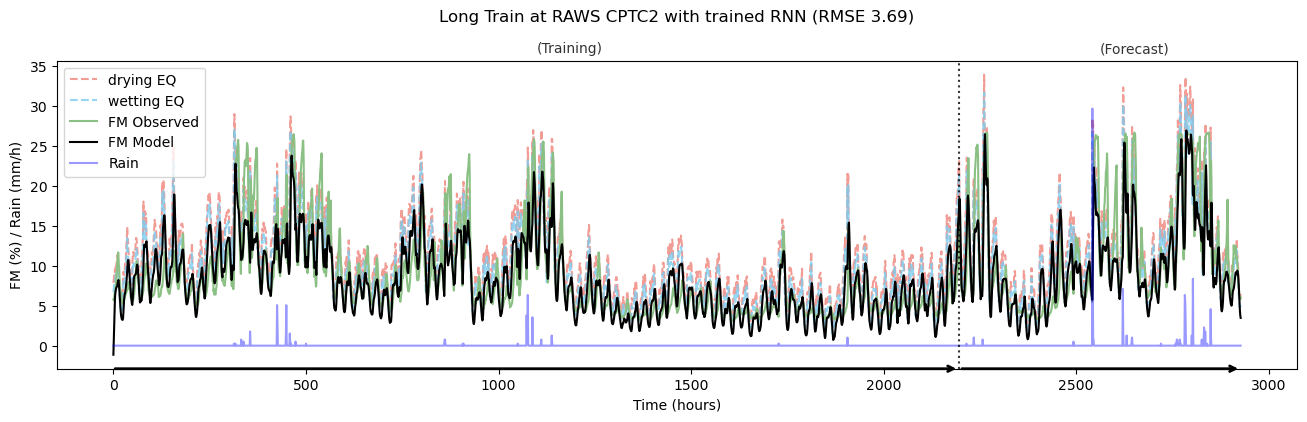

CPTC2 Training 1 to 2196 hours RMSE:   2.4354
CPTC2 Prediction 2197 to 2928 hours RMSE: 3.6908
         Augmented KF  RNN initial  RNN trained
train        0.533546     2.811002     2.435432
predict      4.614618     4.117922     3.690769
all          2.353121     3.188357     2.802488
case= CHRC2

*****  CHRC2  *****

CHRC2 Training 1 to 2195 hours RMSE:   0.5738
CHRC2 Prediction 2196 to 2926 hours RMSE: 3.0489
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


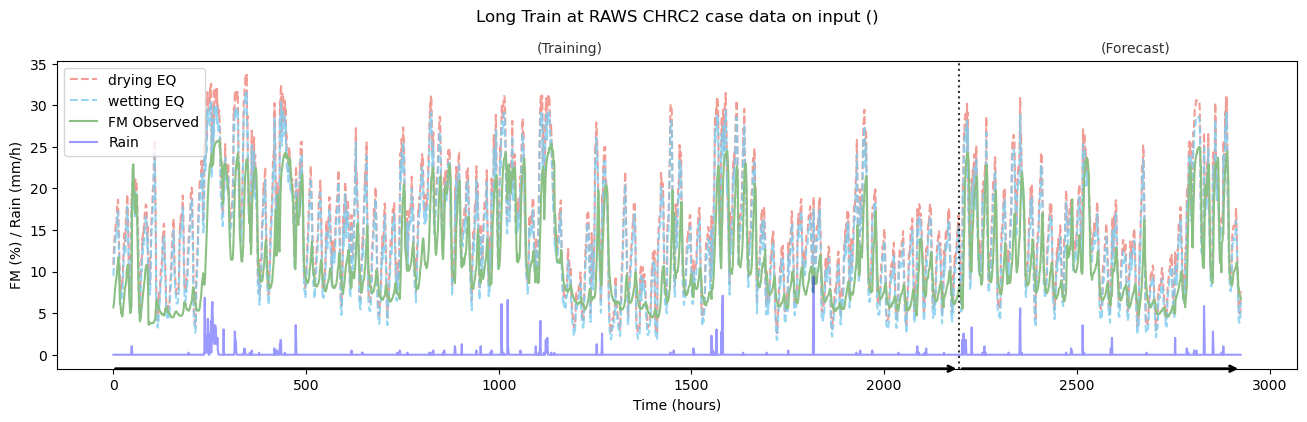

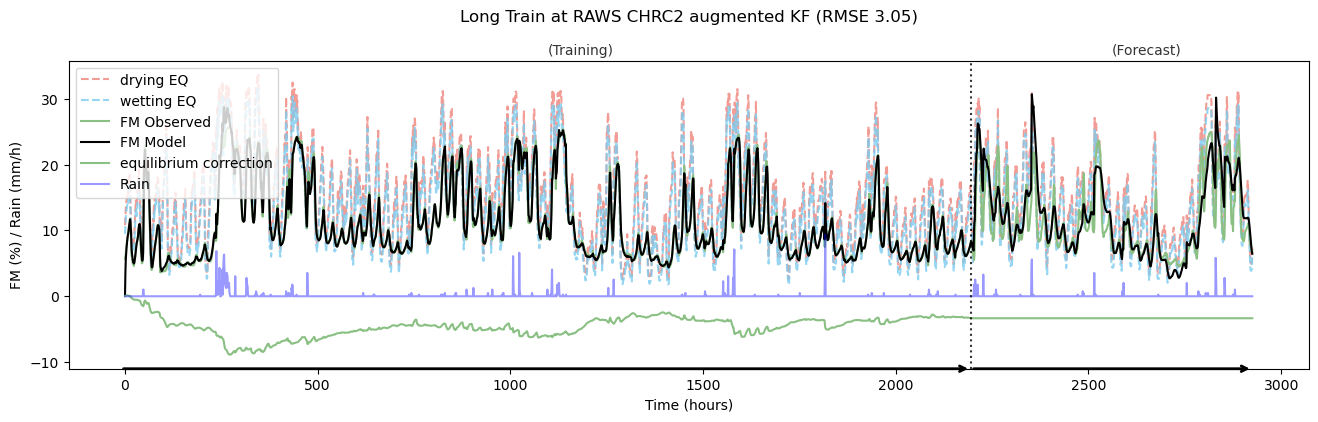

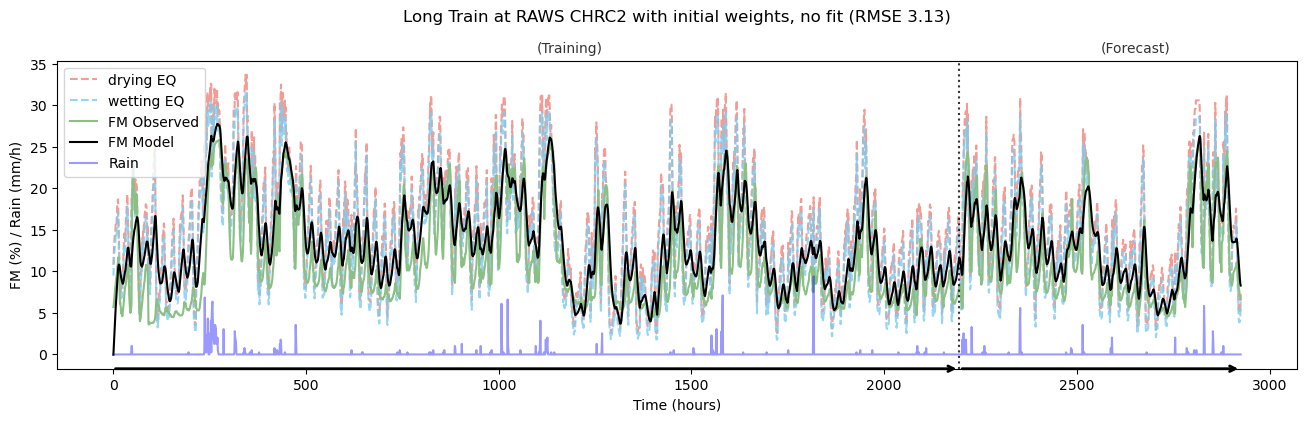

CHRC2 Training 1 to 2195 hours RMSE:   3.3718
CHRC2 Prediction 2196 to 2926 hours RMSE: 3.1349
resetting random seeds to 123
check - hash weights: 5.208581994363425e+19


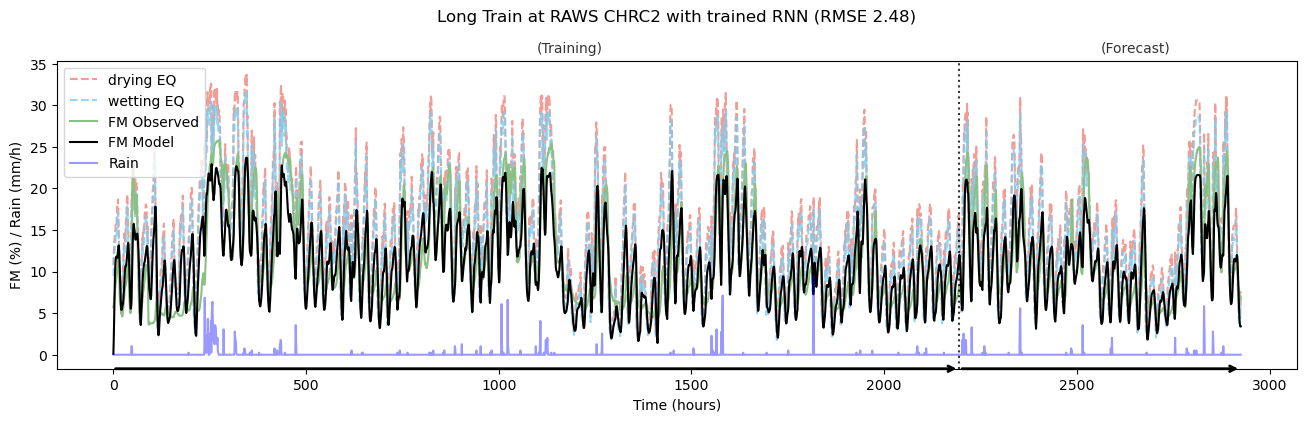

CHRC2 Training 1 to 2195 hours RMSE:   2.9574
CHRC2 Prediction 2196 to 2926 hours RMSE: 2.4762
         Augmented KF  RNN initial  RNN trained
train        0.573776     3.371821     2.957415
predict      3.048929     3.134871     2.476234
all          1.602927     3.314212     2.844839
case= DYKC2

*****  DYKC2  *****

DYKC2 Training 1 to 2192 hours RMSE:   0.4464
DYKC2 Prediction 2193 to 2922 hours RMSE: 2.6437
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


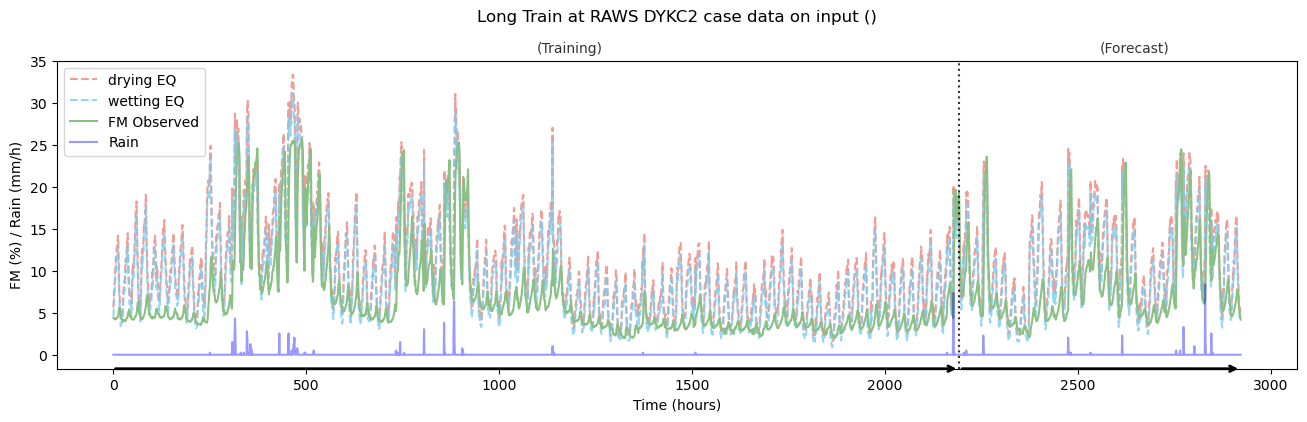

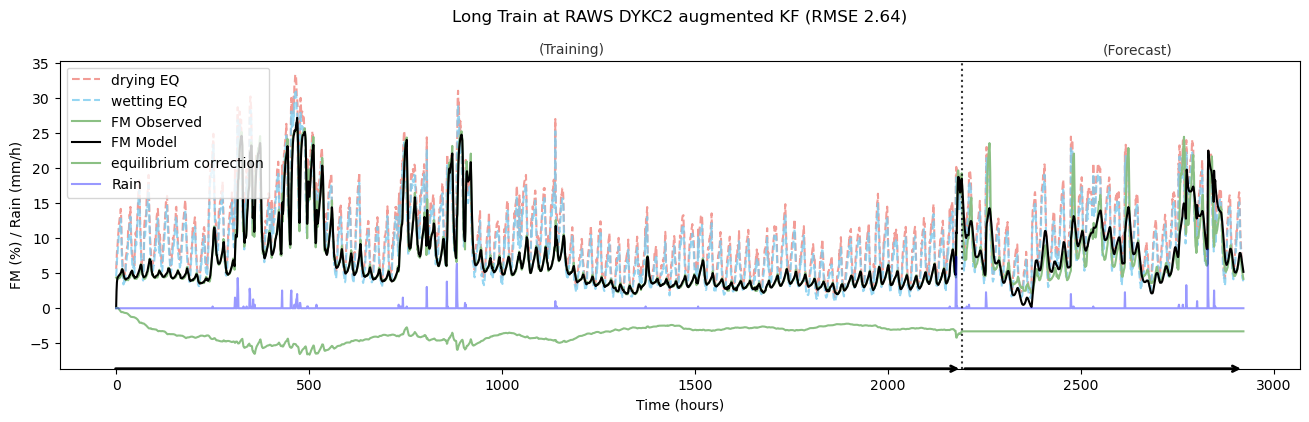

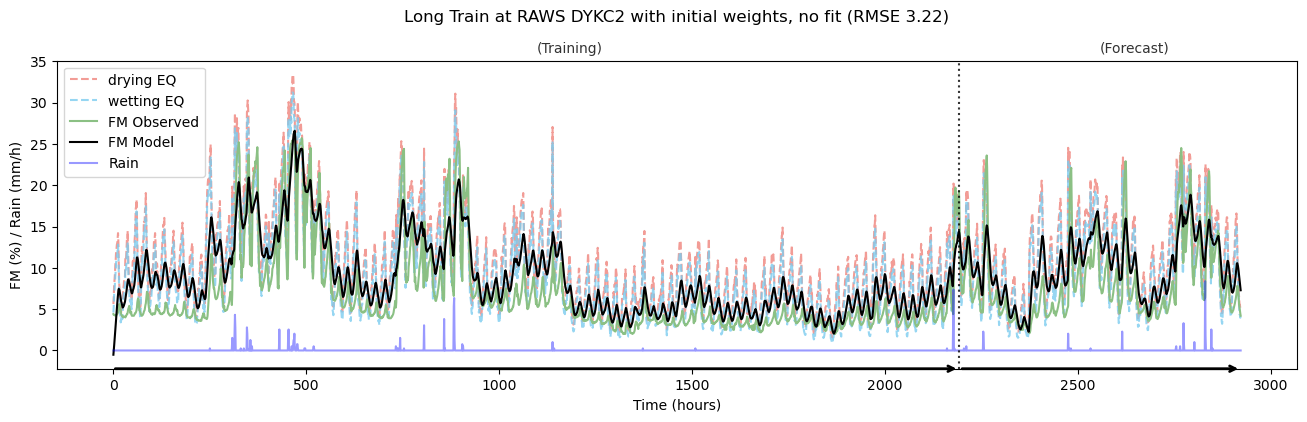

DYKC2 Training 1 to 2192 hours RMSE:   2.9928
DYKC2 Prediction 2193 to 2922 hours RMSE: 3.2203
resetting random seeds to 123
check - hash weights: 3.6286226145273192e+19


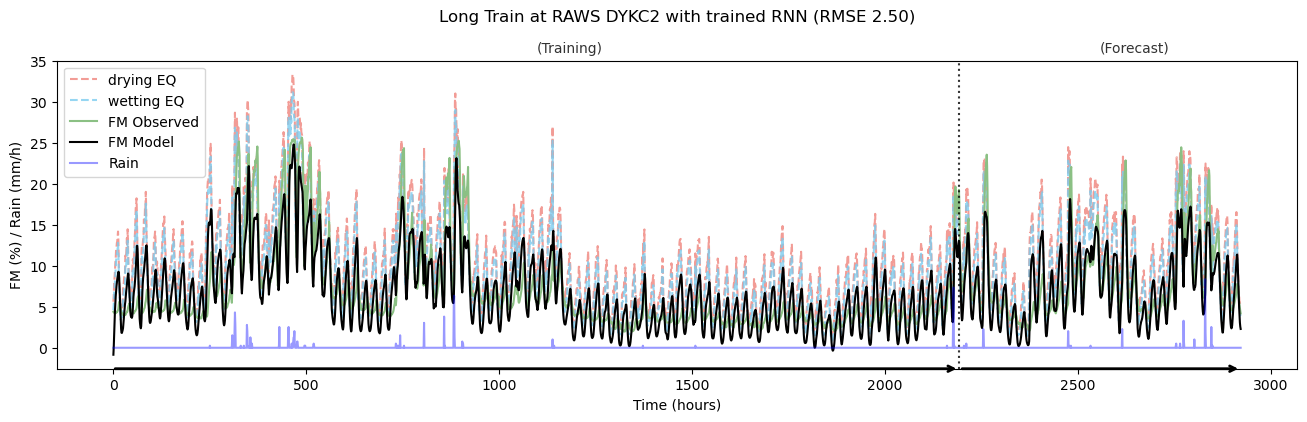

DYKC2 Training 1 to 2192 hours RMSE:   2.574
DYKC2 Prediction 2193 to 2922 hours RMSE: 2.5035
         Augmented KF  RNN initial  RNN trained
train        0.446426     2.992810     2.574003
predict      2.643675     3.220302     2.503459
all          1.376795     3.051234     2.556562
case= LPFC2

*****  LPFC2  *****

LPFC2 Training 1 to 2194 hours RMSE:   0.4893
LPFC2 Prediction 2195 to 2925 hours RMSE: 2.1931
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


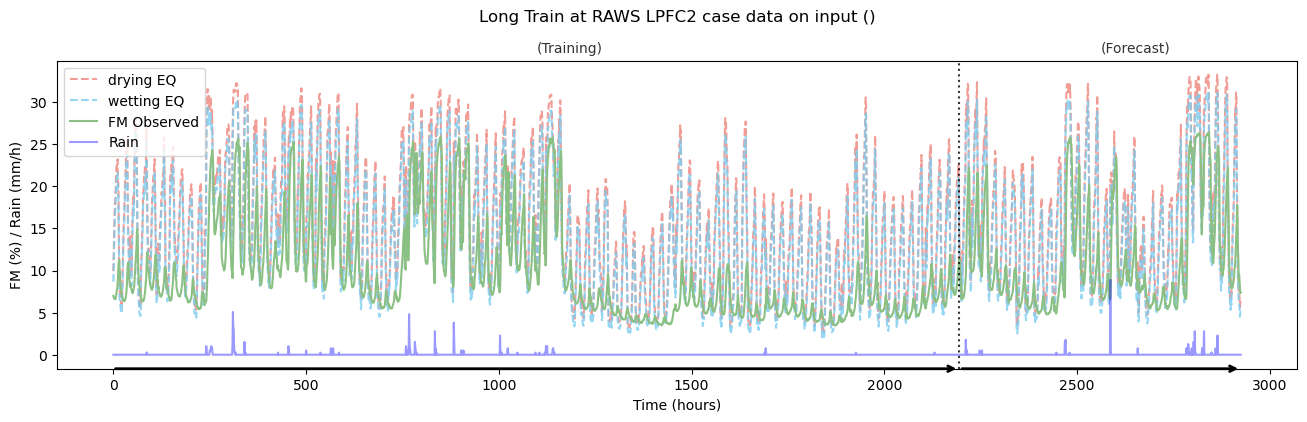

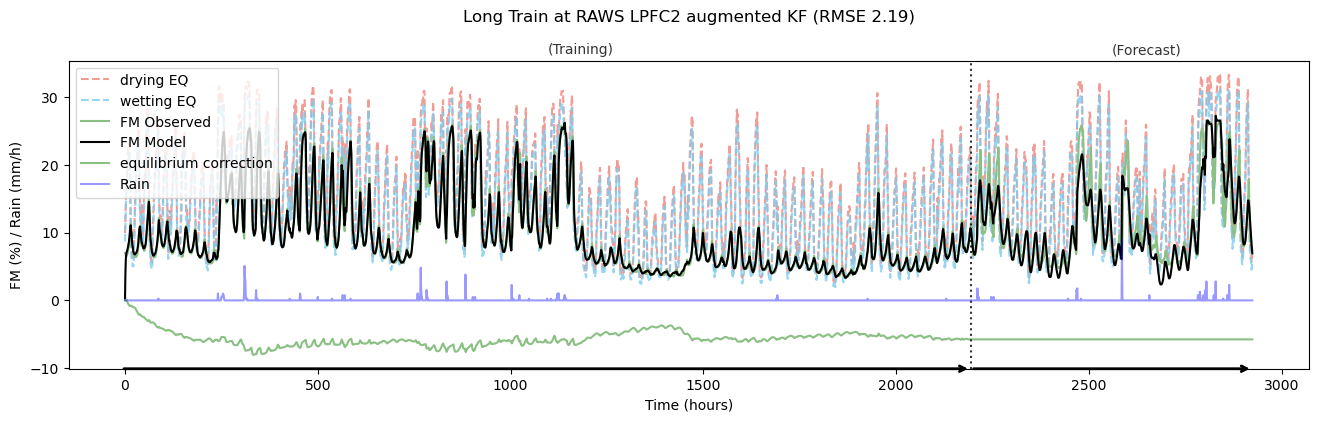

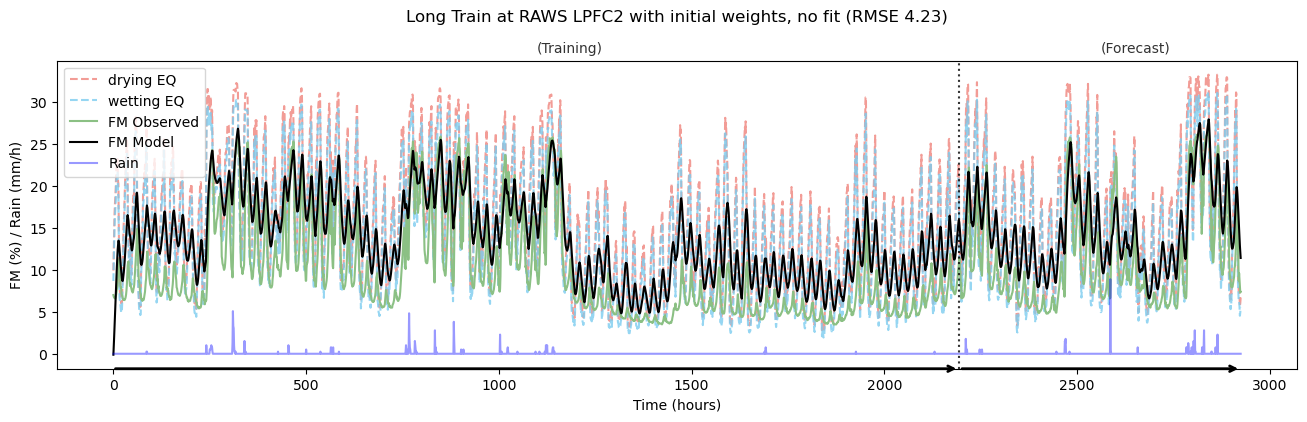

LPFC2 Training 1 to 2194 hours RMSE:   4.7438
LPFC2 Prediction 2195 to 2925 hours RMSE: 4.2261
resetting random seeds to 123
check - hash weights: 4.1823677489691386e+19


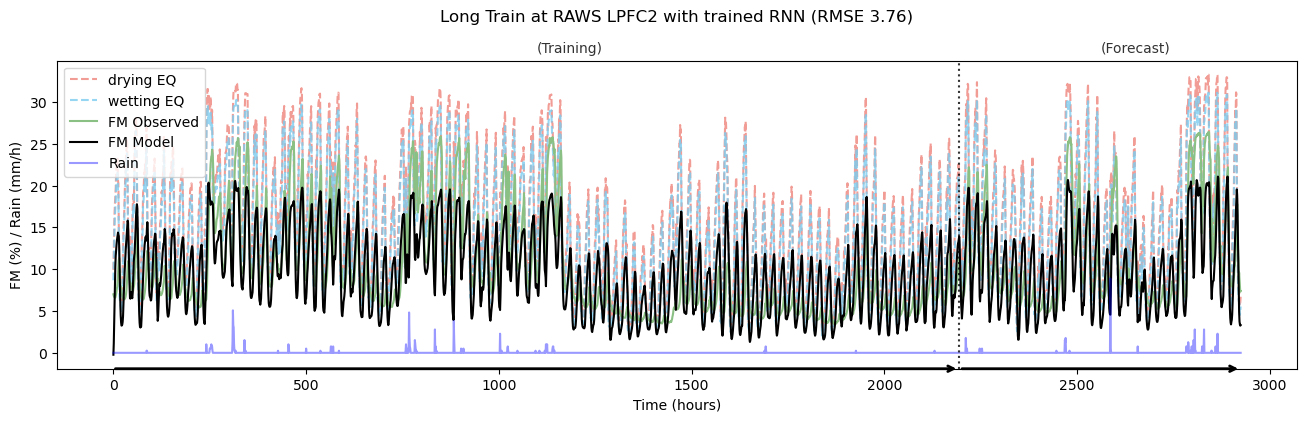

LPFC2 Training 1 to 2194 hours RMSE:   3.5437
LPFC2 Prediction 2195 to 2925 hours RMSE: 3.7559
         Augmented KF  RNN initial  RNN trained
train        0.489286     4.743845     3.543707
predict      2.193080     4.226102     3.755883
all          1.175398     4.619895     3.597906
case= RRAC2

*****  RRAC2  *****

RRAC2 Training 1 to 2195 hours RMSE:   0.5737
RRAC2 Prediction 2196 to 2926 hours RMSE: 2.9329
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


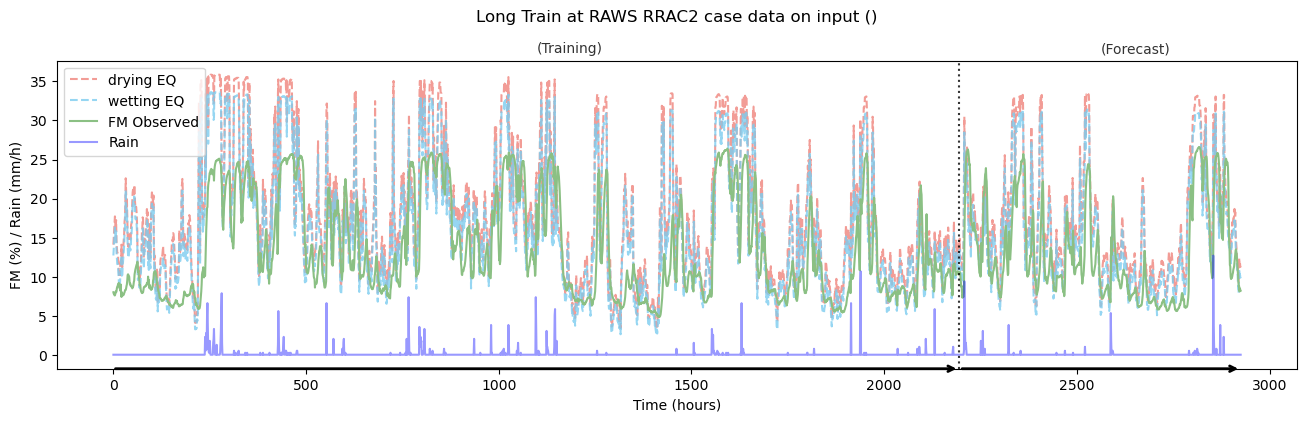

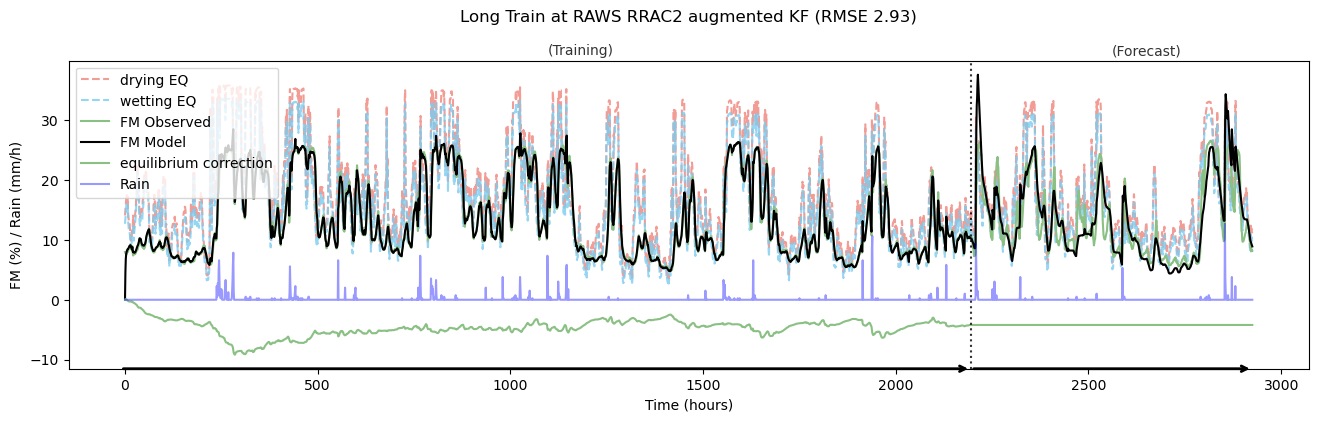

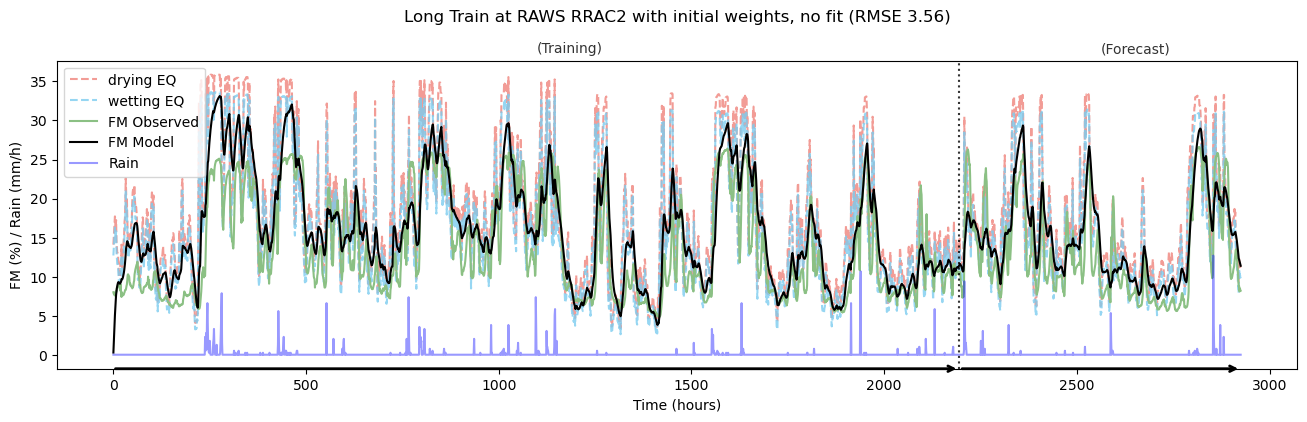

RRAC2 Training 1 to 2195 hours RMSE:   3.6725
RRAC2 Prediction 2196 to 2926 hours RMSE: 3.5631
resetting random seeds to 123
check - hash weights: 2.0222922257038914e+19


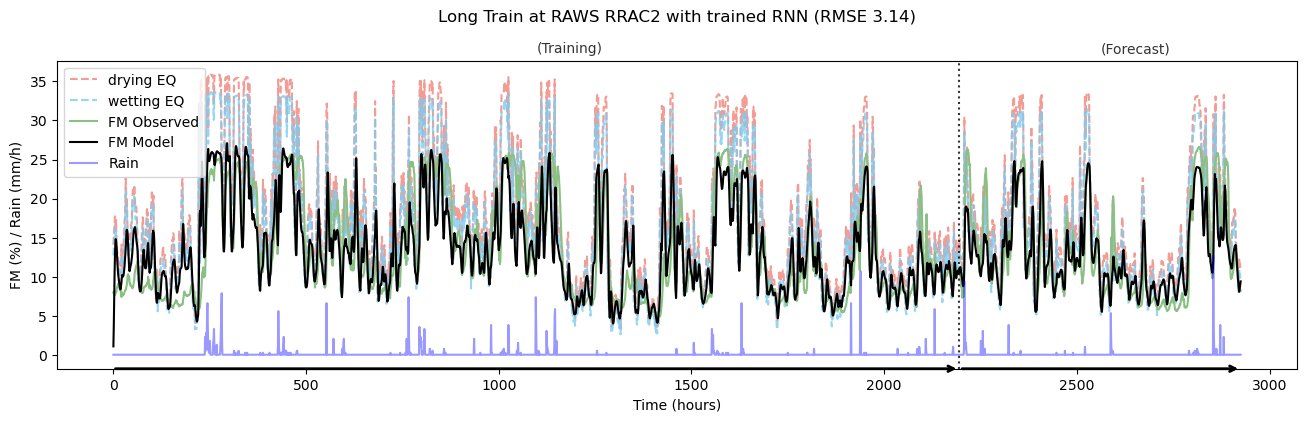

RRAC2 Training 1 to 2195 hours RMSE:   3.3847
RRAC2 Prediction 2196 to 2926 hours RMSE: 3.1384
         Augmented KF  RNN initial  RNN trained
train        0.573677     3.672468     3.384715
predict      2.932854     3.563116     3.138402
all          1.547844     3.645456     3.324889
case= TT562

*****  TT562  *****

TT562 Training 1 to 2196 hours RMSE:   0.7886
TT562 Prediction 2197 to 2927 hours RMSE: 3.3537
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


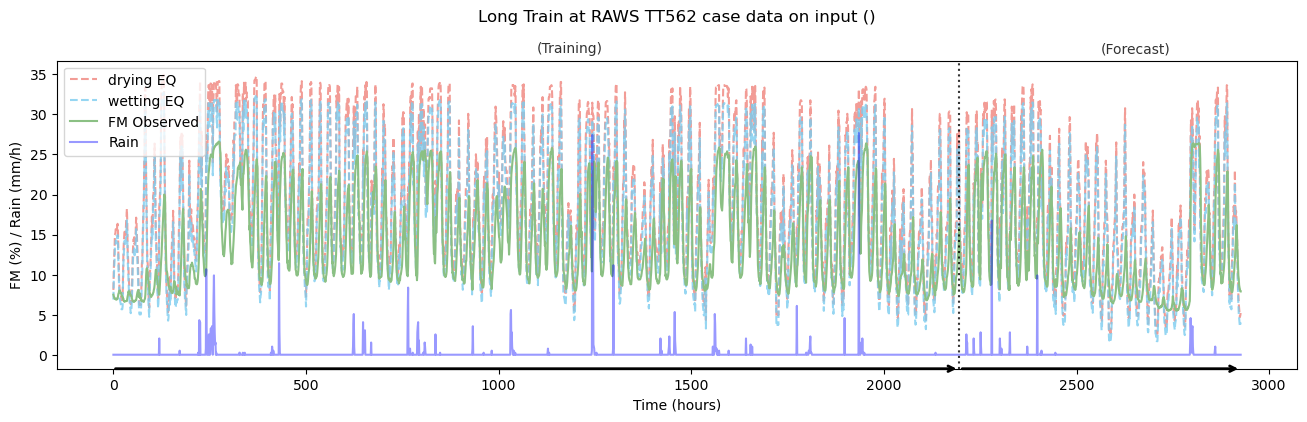

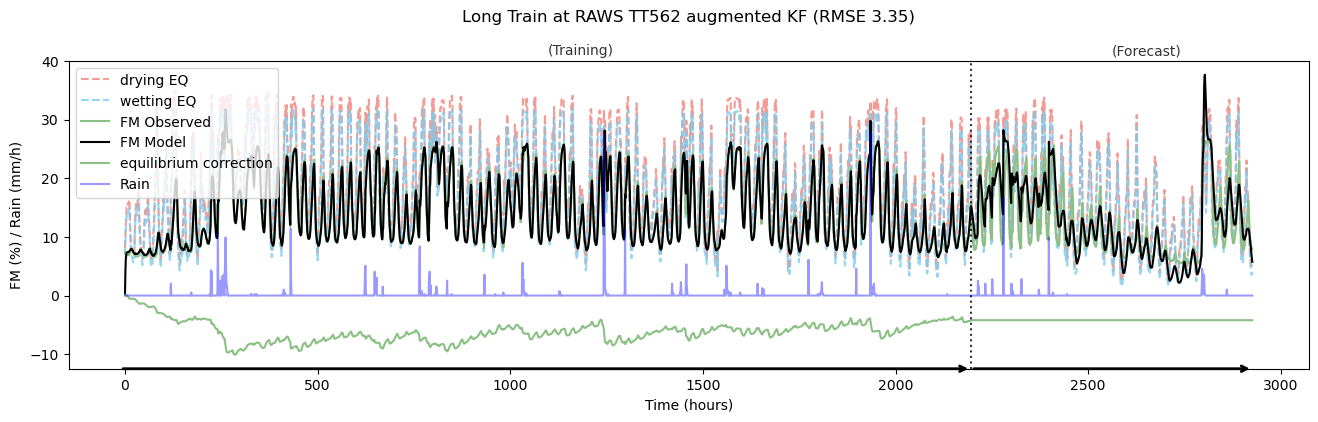

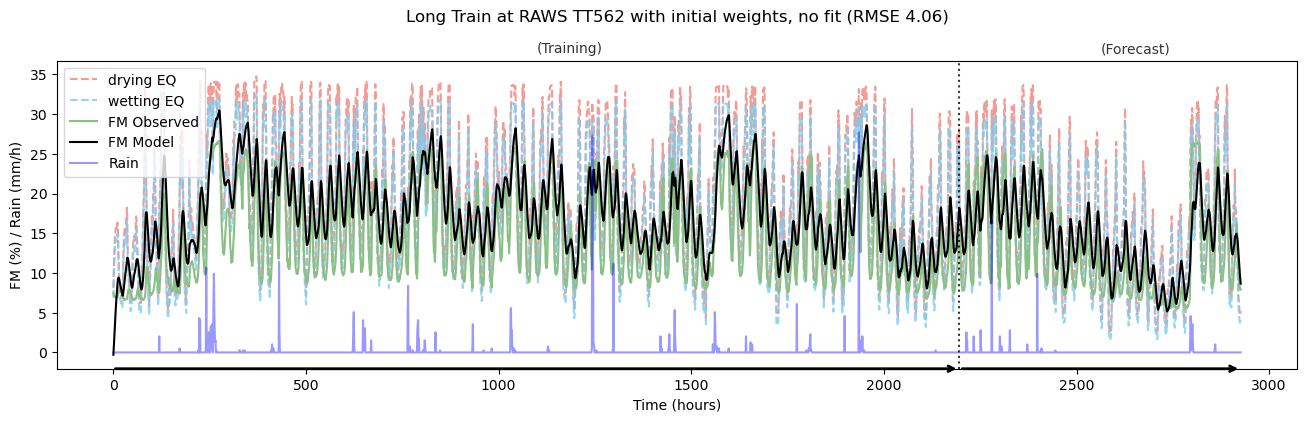

TT562 Training 1 to 2196 hours RMSE:   4.4542
TT562 Prediction 2197 to 2927 hours RMSE: 4.0635
resetting random seeds to 123
check - hash weights: 4.732929722876363e+19


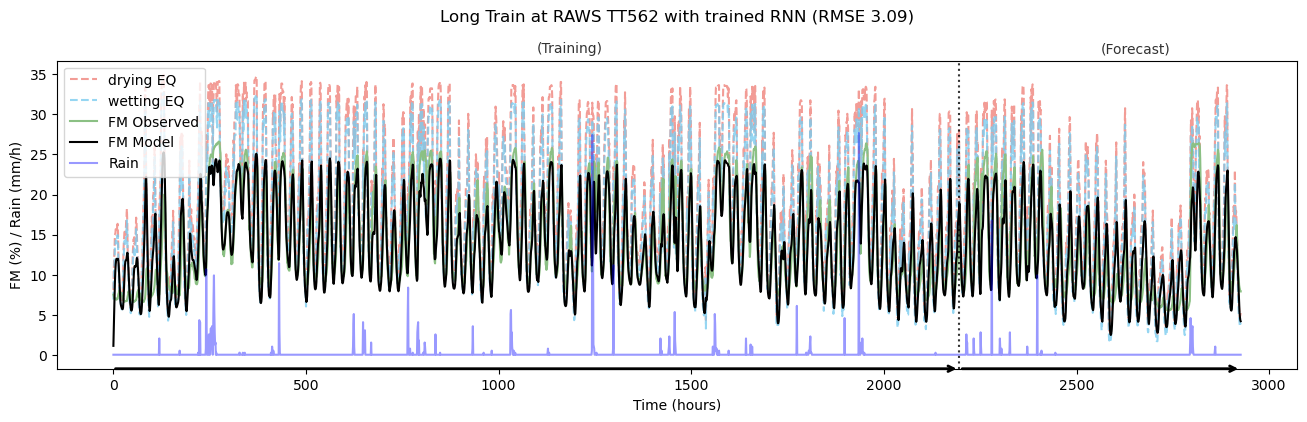

TT562 Training 1 to 2196 hours RMSE:   2.1878
TT562 Prediction 2197 to 2927 hours RMSE: 3.088
         Augmented KF  RNN initial  RNN trained
train        0.788566     4.454175     2.187838
predict      3.353668     4.063481     3.087985
all          1.809814     4.359883     2.443905
case= TT696

*****  TT696  *****

TT696 Training 1 to 2196 hours RMSE:   0.8945
TT696 Prediction 2197 to 2927 hours RMSE: 4.0699
resetting random seeds to 123
Fitting skipped, using initial weights
check - hash weights: 3.735307973219784e+19


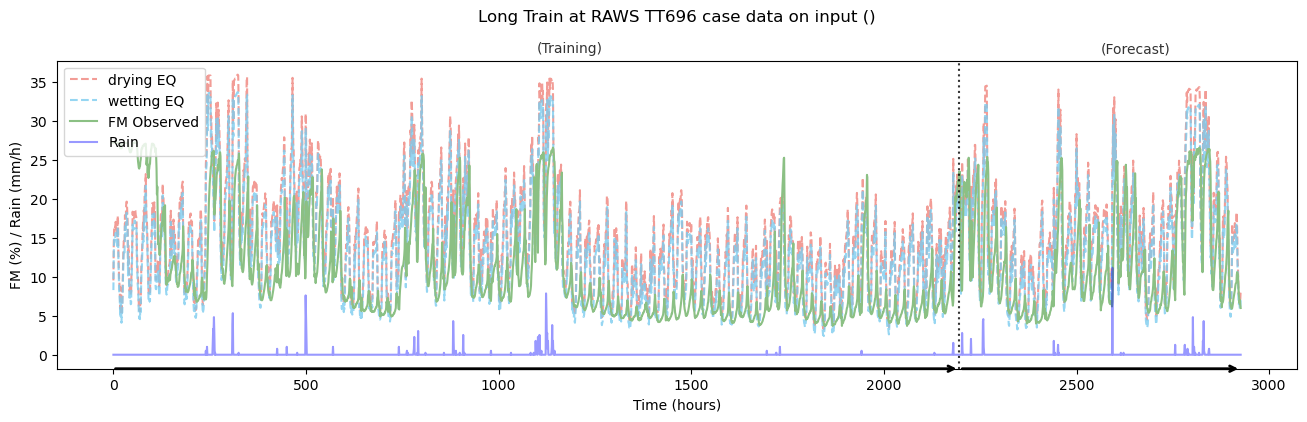

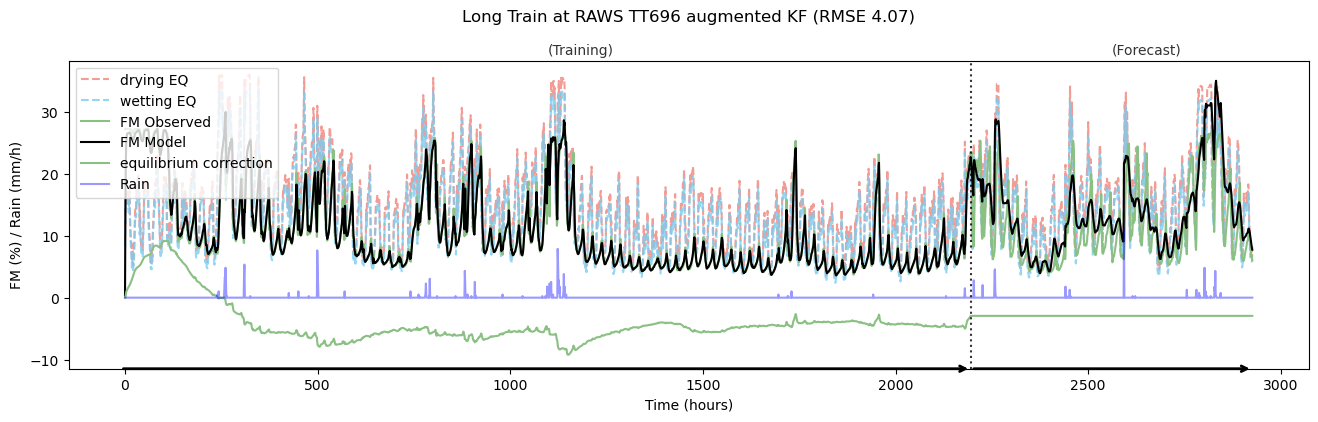

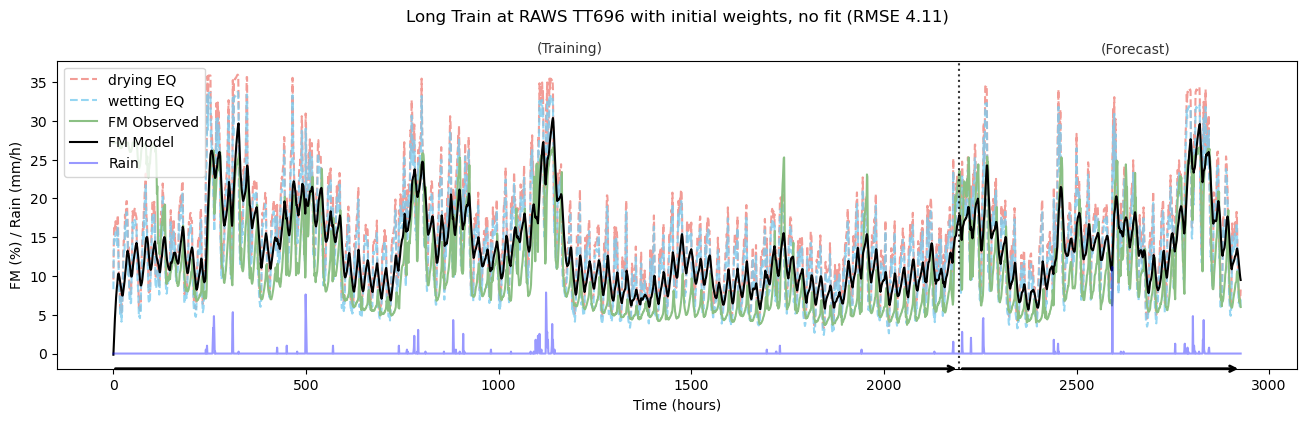

TT696 Training 1 to 2196 hours RMSE:   5.3783
TT696 Prediction 2197 to 2927 hours RMSE: 4.1082
resetting random seeds to 123
check - hash weights: 6.555709535653772e+19


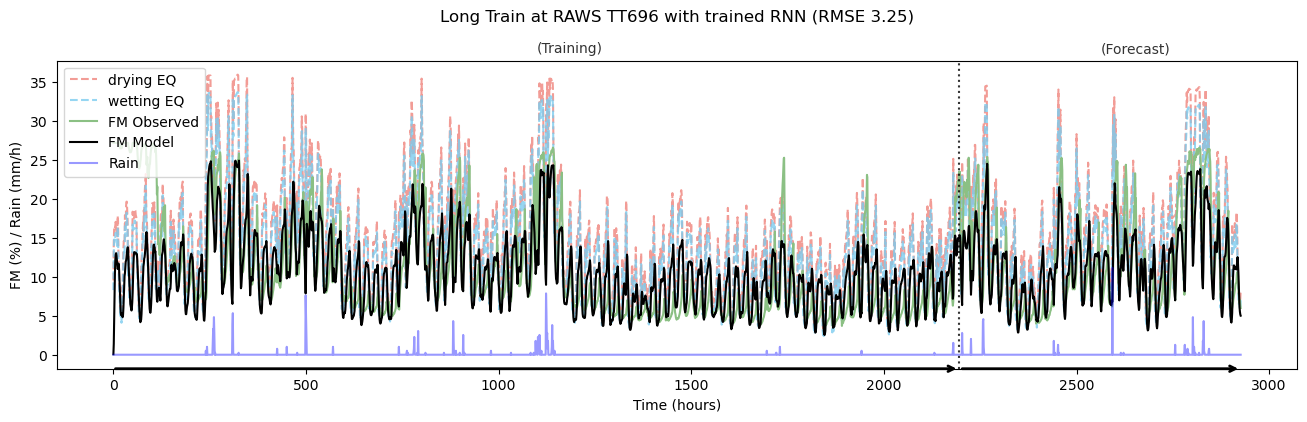

TT696 Training 1 to 2196 hours RMSE:   4.9324
TT696 Prediction 2197 to 2927 hours RMSE: 3.2469
         Augmented KF  RNN initial  RNN trained
train        0.894507     5.378339     4.932391
predict      4.069903     4.108243     3.246872
all          2.176487     5.090914     4.570059
cases= ['CPTC2', 'CHRC2', 'DYKC2', 'LPFC2', 'RRAC2', 'TT562', 'TT696']


In [10]:
# output={}
# output_path='output.json'
# print('params_sets.keys()=',param_sets.keys())
# print(json.dumps(param_sets,indent=4,sort_keys=True))

for i in param_sets:
#for params in param_sets:
    print('i=',i)
    params=param_sets[i]
    if params['cases'] == 'all':
        params['cases'] = list(test_dict.keys())
        print("expanding 'all' to",params['cases'])
    # output[i]={'params':params,'cases':{}}
    cases = params['cases']
    print('cases=',cases)
    for case in cases:
        print('case=',case)
        # print(json.dumps(params,indent=4,sort_keys=True))
        case_data=test_dict[case]
        if params['synthetic'] or 'Synth' not in case_data['title']: 
            # output[i]['cases'][case]=run_case(case_data,params)  # add to results
            r = run_case(case_data,params)
            print(pd.DataFrame(r))
            # print('*** params',i,'case',case,'summary ***')
            # print('params=',params)
            # print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
            # print('writing the results to file',output_path)
            # json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
    print('cases=',cases)
# print(json.dumps(output,indent=4,sort_keys=True))